Accuracy: 81.23%


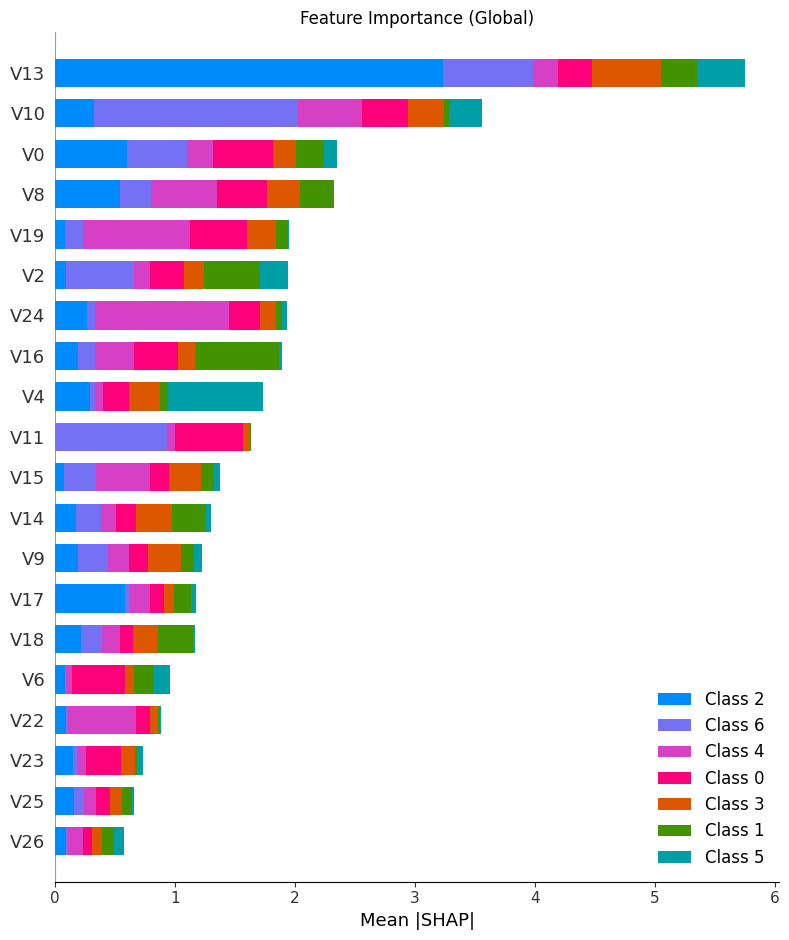

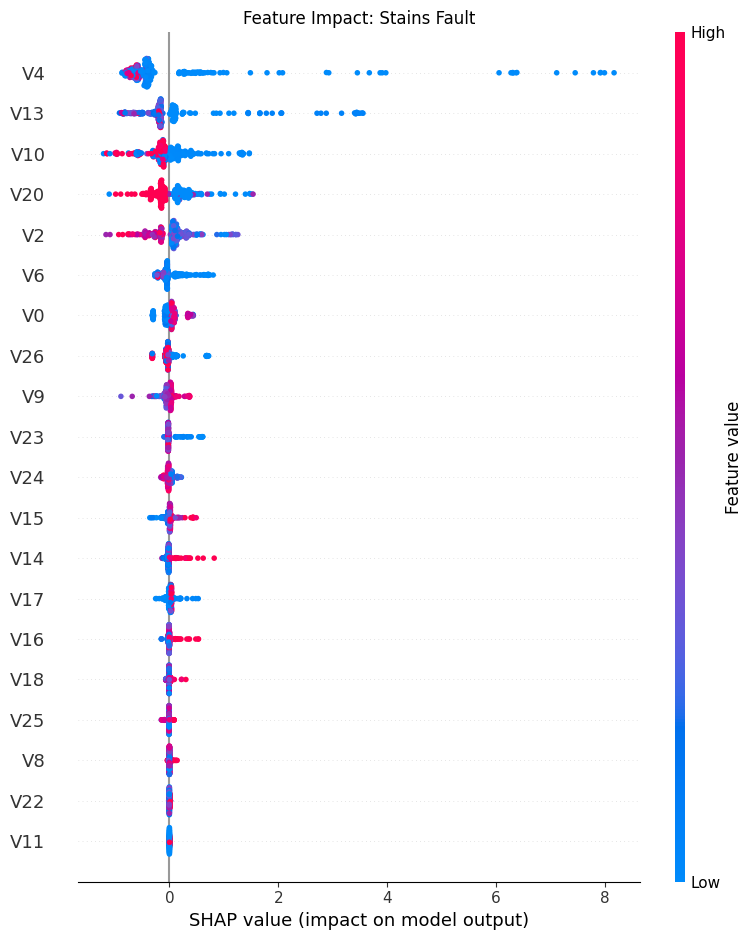

<Figure size 800x600 with 0 Axes>

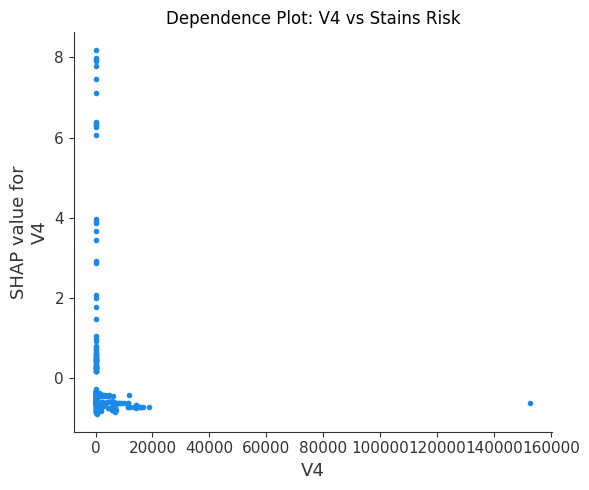


[Analysis Report]
Target Class: Stains (Idx: 5)
Top Driver: V4
Interpretation:
 - Bar Plot: Global sensor importance.
 - Beeswarm: Directional impact (Red=High val, Blue=Low val).
 - Dependence: Non-linear thresholds for V4.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import zipfile
import urllib.request
from io import BytesIO

# Config
DATA_URL = "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip"
CLASS_NAMES = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

# ---------------------------------------------------------
# ETL & Preprocessing
# ---------------------------------------------------------
def fetch_and_process_data():
    # 1. Download & Parse
    with urllib.request.urlopen(DATA_URL) as resp:
        with zipfile.ZipFile(BytesIO(resp.read())) as zf:
            target = next(n for n in zf.namelist() if "Faults.NNA" in n or "faults" in n.lower())
            with zf.open(target) as f:
                df = pd.read_csv(f, sep=r'\s+', header=None)

    # 2. Rename Columns
    feat_cols = [f"V{i}" for i in range(27)]
    df.columns = feat_cols + CLASS_NAMES

    # 3. Clean: Keep only single-label rows
    mask = df[CLASS_NAMES].sum(axis=1) == 1
    df_clean = df[mask].copy()

    X = df_clean[feat_cols]
    y_raw = df_clean[CLASS_NAMES].idxmax(axis=1)

    # 4. Encode Targets
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # 5. Feature Selection: Drop collinear (>0.95)
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X = X.drop(columns=to_drop)

    return X, y, le, X.columns.tolist()

# ---------------------------------------------------------
# Training
# ---------------------------------------------------------
X, y, le, feature_names = fetch_and_process_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Init & Fit LGBM
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test)):.2%}")

# ---------------------------------------------------------
# SHAP Analysis
# ---------------------------------------------------------
explainer = shap.TreeExplainer(model)

# Compute raw SHAP values
shap_obj = explainer(X_test)

# Slice: Extract specific class ('Stains')
# Shape: (n_samples, n_features, n_classes) -> (n_samples, n_features)
stains_idx = list(le.classes_).index('Stains')
stains_explanation = shap_obj[:, :, stains_idx]

# Prep: Convert to list for multiclass bar plot
shap_values_list = [shap_obj.values[:,:,i] for i in range(shap_obj.values.shape[2])]

# ---------------------------------------------------------
# Visualization
# ---------------------------------------------------------

# 1. Global Importance (Bar)
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Global)")
shap.summary_plot(shap_values_list, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.savefig('shap_summary_bar.png')
plt.show()

# 2. Stains Risk (Beeswarm)
plt.figure(figsize=(10, 6))
plt.title("Feature Impact: Stains Fault")
shap.summary_plot(stains_explanation, X_test, show=False)
plt.tight_layout()
plt.savefig('shap_stains_beeswarm.png')
plt.show()

# 3. Top Feature Dependence
# Identify top feature automatically
top_feature_idx = np.abs(stains_explanation.values).mean(axis=0).argmax()
top_feature_name = X_test.columns[top_feature_idx]

plt.figure(figsize=(8, 6))
shap.dependence_plot(
    top_feature_name,
    stains_explanation.values,
    X_test,
    interaction_index=None,
    show=False
)
plt.title(f"Dependence Plot: {top_feature_name} vs Stains Risk")
plt.tight_layout()
plt.savefig('shap_dependence.png')
plt.show()

# ---------------------------------------------------------
# Output Summary
# ---------------------------------------------------------
def print_summary():
    print(f"\n[Analysis Report]")
    print(f"Target Class: Stains (Idx: {stains_idx})")
    print(f"Top Driver: {top_feature_name}")
    print(f"Interpretation:")
    print(f" - Bar Plot: Global sensor importance.")
    print(f" - Beeswarm: Directional impact (Red=High val, Blue=Low val).")
    print(f" - Dependence: Non-linear thresholds for {top_feature_name}.")

if __name__ == "__main__":
    print_summary()